# 載入package

In [1]:
import numpy as np
import pandas as pd
from glob import glob
from toolz import pipe, partial
from os.path import join, splitext
from mpmath import mp

In [2]:
import numpy as np
from collections import defaultdict
from scipy.optimize import minimize
pd.set_option('display.max_columns', None)

In [3]:
from sklearn.preprocessing import LabelEncoder

In [4]:
from scipy.linalg import block_diag
from numpy.linalg import inv
import copy

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 整理資料

In [77]:
def get_data(sackmann_dir, tour='atp', keep_davis_cup=False):

    all_csvs = glob(join(sackmann_dir, f'*{tour}_matches_doubles_????.csv'))
    all_csvs = sorted(all_csvs, key=lambda x: int(splitext(x)[0][-4:]))

    levels_to_drop = ['C', 'S']

    if not keep_davis_cup:
        levels_to_drop.append('D')

    data = pipe(all_csvs,
                # Read CSV
                lambda y: map(partial(pd.read_csv, encoding="ISO=8859-1",index_col=False), y),
                # Drop NAs in important fields
                lambda y: map(lambda x: x.dropna(
                    subset=['winner1_name', 'loser1_name', 'winner2_name', 'loser2_name','score']),
                    y),
                # Drop retirements and walkovers
                # TODO: Make this optional
                lambda y: map(lambda x:
                              x[~x['score'].astype(str).str.contains(
                                'RET|W/O|DEF|nbsp|Def.')],
                              y),
                # Drop scores that appear truncated
                lambda y: map(lambda x: x[
                    x['score'].astype(str).str.len() > 4],
                    y),
                # Drop challengers and futures
                # TODO: Make this optional too
                lambda y: map(lambda x: x[
                    ~x['tourney_level'].isin(levels_to_drop)],
                    y),
                pd.concat,
                )

    round_numbers = {
        'R128': 1,
        'RR': 1,
        'R64': 2,
        'R32': 3,
        'R16': 4,
        'QF': 5,
        'SF': 6,
        'F': 7
    }

    # Drop rounds outside this list
    to_keep = data['round'].isin(round_numbers)
    data = data[to_keep]

    # Add a numerical round number
    data['round_number'] = data['round'].replace(round_numbers)

    # Add date information
    data['tourney_date'] = pd.to_datetime(
        data['tourney_date'].astype(int).astype(str), format='%Y%m%d')
    data['year'] = data['tourney_date'].dt.year

    # Sort by date and round and reset index
    data = data.sort_values(['tourney_date', 'round_number'])
    data = data.reset_index(drop=True)

    data['pts_won_serve_winner'] = data['w_1stWon'] + data['w_2ndWon']
    data['pts_won_serve_loser'] = data['l_1stWon'] + data['l_2ndWon']

    data['pts_played_serve_winner'] = data['w_svpt']
    data['pts_played_serve_loser'] = data['l_svpt']

    # Add serve % won
    data['spw_winner'] = (data['w_1stWon'] + data['w_2ndWon']) / data['w_svpt']
    data['spw_loser'] = (data['l_1stWon'] + data['l_2ndWon']) / data['l_svpt']

    return data

資料來自:https://github.com/JeffSackmann/tennis_atp

將雙打的資料整合起來

In [78]:
data = get_data('tennis_atp-master/tennis_atp-master/')

收集2010年至2019年的比賽

In [79]:
data = data[data['tourney_date'].dt.year >= 2010]
to_use = data[data['tourney_date'].dt.year <= 2019]

將資料儲存至csv檔

In [80]:
to_use.to_csv("double.csv",index=False)

In [81]:
Train = to_use[to_use['tourney_date'].dt.year <= 2017]

In [82]:
Test = to_use[to_use['tourney_date'].dt.year > 2017]

各資料集的場地資料

In [83]:
Train['surface'].value_counts()

Hard     5548
Clay     3112
Grass    1199
Name: surface, dtype: int64

In [84]:
Test['surface'].value_counts()

Hard     1464
Clay      767
Grass     340
Name: surface, dtype: int64

In [85]:
to_use['surface'].value_counts()

Hard     7012
Clay     3879
Grass    1539
Name: surface, dtype: int64

資料集的比賽場數

|Dataset|Train|Test|Total|
|---|---|---|---|
|Begin|2010|2018|2010|
|End|2017|2019|2019|
|Hard|5548|1464|7012|
|Clay|3112|767|3879|
|Grass|1199|340|1539|
|Total|9859|2571|12430|

## Train the model

In [86]:
def encode_marks(marks):

    encoder = LabelEncoder()
    encoded = encoder.fit_transform(marks)
    oh = np.zeros((len(marks), len(encoder.classes_)))

    oh[np.arange(len(marks)), encoded] = 1

    return oh, encoder.classes_

In [87]:
Train = Train.reset_index()
surface = encode_marks(Train['surface'])[0]
winners = Train[['winner1_name','winner2_name']]
losers = Train[['loser1_name','loser2_name']]
Test = Test.reset_index()
to_use = to_use.reset_index()

In [17]:
def calculate_win_prob(mu_ik, mu_jk, c_ij):
    '''
    Calculate the win probability of p_ijk
    '''
    return np.array(mp.exp(mu_ik / c_ij)/(mp.exp(mu_ik / c_ij) + mp.exp(mu_jk / c_ij)), dtype = 'float64')

In [18]:
def calculate_discrepancy(s_ijk, mu_ik, mu_jk, c_ij):
    '''
    Calculate the discrepency between predicted and actual outcome.
    '''
    p_ijk = calculate_win_prob(mu_ik, mu_jk, c_ij)
    return -s_ijk * np.log(p_ijk) - (1 - s_ijk) * np.log(1-p_ijk)

$\mu'_{\theta} = \mu_{\theta} - {H}^{-1}(\mu_{\theta})j(\mu_{\theta}) = \mu_{\theta} + \delta$

$j(\mu_{\theta}) =\dfrac{1}{c_3} \begin{bmatrix}
0\\0\\s_{iq3} - \dfrac{e^{\mu_{i3}/c_3}}{e^{\mu_{i3}/c_3}+e^{\mu_{q3}/c_3}}\\0\\0\\1-s_{iq3}-\dfrac{e^{\mu_{q3}/c_3}}{e^{\mu_{i3}/c_3}+e^{\mu_{q3}/c_3}}
\end{bmatrix}$

$H(\mu_{\theta})= - \Sigma^{-1} + \dfrac{1}{c^2_3}
\begin{bmatrix}
0&0&0&0&0&0\\
0&0&0&0&0&0\\
0&0&-\dfrac{e^{(\mu_{i3}+\mu_{q3})/c_3}}{(e^{\mu_{i3}/c_3}+e^{\mu_{q3}/c_3})^2}&0&0&\dfrac{e^{(\mu_{i3}+\mu_{q3})/c_3}}{(e^{\mu_{i3}/c_3}+e^{\mu_{q3}/c_3})^2}\\
0&0&0&0&0&0\\
0&0&0&0&0&0\\
0&0&\dfrac{e^{(\mu_{i3}+\mu_{q3})/c_3}}{(e^{\mu_{i3}/c_3}+e^{\mu_{q3}/c_3})^2}&0&0&-\dfrac{e^{(\mu_{i3}+\mu_{q3})/c_3}}{(e^{\mu_{i3}/c_3}+e^{\mu_{q3}/c_3})^2}\\
\end{bmatrix}$

In [19]:
def calculate_ratings(winners, losers, surface, beta, variance_1, variance_2, variance_3, rho_12, rho_13, rho_23):
    '''
    Calculate B-T model ratings.
    Args:
    winners: The array of winners for each of N contests, of shape [N, 2].
    losers: The array of losers for each of N contests, of shape [N, 2].
    surface: The array of surfaces for each of N contest, of shape [N, 3].
    beta: The uncontral variances of the game
    start_variance_1: The initial variance of the surface 1
    start_variance_2: The initial variance of the surface 2
    start_variance_3: The initial variance of the surface 3
    rho_12: The initial correlation coefficient between surface 1 and surface 2
    rho_13: The initial correlation coefficient between surface 1 and surface 3
    rho_23: The initial correlation coefficient between surface 2 and surface 3
    '''
    prior_ratings = defaultdict(lambda :(np.array([[1500],[1500],[1500]],dtype = 'float64')))
    
    surface_variance = np.array([[variance_1, rho_12 * np.sqrt(variance_1*variance_2), rho_13 * np.sqrt(variance_1*variance_3)],
                                [rho_12 * np.sqrt(variance_1*variance_2), variance_2, rho_23 * np.sqrt(variance_2*variance_3)],
                                [rho_13 * np.sqrt(variance_1*variance_3), rho_23 * np.sqrt(variance_2*variance_3), variance_3]])
    
    rating_history = list()
    total_discrepancy = 0
    for game in np.arange(winners.shape[0]):
        # current winners & losers
        cur_winner_1, cur_winner_2 = winners['winner1_name'][game], winners['winner2_name'][game]
        cur_loser_1, cur_loser_2 = losers['loser1_name'][game], losers['loser2_name'][game]
        # current surface [1,3]
        cur_surface = surface[game]
        # current player
        current_player = [cur_winner_1, cur_winner_2, cur_loser_1, cur_loser_2]
        # check whether the player play
        for player in current_player:
            if player not in prior_ratings:
                prior_ratings[player]
        # save the prior rating
        rating_history.append(copy.deepcopy(prior_ratings))
        
        new_rating = prior_ratings.copy()
        # winners & loser rating
        winner_1, winner_2 = new_rating[cur_winner_1], new_rating[cur_winner_2]
        loser_1, loser_2 = new_rating[cur_loser_1], new_rating[cur_loser_2]
        # team rating
        winner = winner_1 + winner_2
        loser = loser_1 + loser_2
        # calculate sigma_k
        sigma_k = cur_surface.dot(surface_variance).dot(cur_surface)        
        # calculate c_ij        
        c_ij = np.sqrt(sigma_k + sigma_k + 2 * beta **2)

        # calculate p(x)
        mu_ik = cur_surface.dot(winner)[0] # float
        mu_jk = cur_surface.dot(loser)[0] #float

        p_s = calculate_win_prob(mu_ik = mu_ik , mu_jk= mu_jk , c_ij= c_ij) # float
 
        # calculate discrepancy
        discrepancy = calculate_discrepancy(s_ijk= 1 , mu_ik = mu_ik, mu_jk= mu_jk, c_ij= c_ij)
        # calculate total discrepancy
        total_discrepancy += discrepancy
        # calculate jacobian 6*1
        jacobian = np.zeros((6,1))
        jacobian[:3,:] = cur_surface.reshape((3,1)) - p_s * cur_surface.reshape((3,1))
        jacobian[3:,:] = -(cur_surface.reshape((3,1)) - p_s * cur_surface.reshape((3,1)))
        jacobian = 1/c_ij * jacobian

        # calculate hessian matrix 6*6
        Sigma = block_diag(surface_variance,surface_variance)
        hes = np.zeros((6,6))
        discre = p_s*(1-p_s) * cur_surface.reshape((3,1)).dot(cur_surface.reshape((1,3)))
        hes[:3,:3] = - discre
        hes[3:,:3] =  discre
        hes[:3,3:] =  discre
        hes[3:,3:] = - discre
        hes = 1/(c_ij**2) * hes 

        hessian = - inv(Sigma) + hes

        # update the team rating
        
        #winner -= inv(hessian).dot(jacobian)[:3,:]
        #loser -= inv(hessian).dot(jacobian)[3:,:]
        # update the winner player & loser player rating
        new_rating[cur_winner_1] -= inv(hessian).dot(jacobian)[:3,:]/2
        new_rating[cur_winner_2] -= inv(hessian).dot(jacobian)[:3,:]/2
        
        new_rating[cur_loser_1] -= inv(hessian).dot(jacobian)[3:,:]/2
        new_rating[cur_loser_2] -= inv(hessian).dot(jacobian)[3:,:]/2
        
        # update prior rating
        prior_ratings = new_rating
        
    return rating_history, total_discrepancy

In [20]:
my = calculate_ratings(winners, losers, surface, 3**2, 100**2, 100**2, 100**2, 0.5, 0.5, 0.5)

In [21]:
def optimize_parameter(
    winners, 
    losers, 
    surface,
    beta = 3 ** 2,
    start_variance_1 = 10 ** 2, 
    start_variance_2 = 10 ** 2, 
    start_variance_3 = 10 ** 2, 
    start_rho_12 = 0.5, 
    start_rho_13 = 0.5, 
    start_rho_23 = 0.5,
    verbose = True,
    tolerance = 1e-2,
):
    '''Fits the parameters in B-T model.
    Args:
    winners: The array of winners for each of N contests, of shape [N, 2].
    losers: The array of losers for each of N contests, of shape [N, 2].
    surface: The array of surfaces for each of N contest, of shape [N, 3].
    beta: The uncontral variances of the game
    start_variance_1: The initial variance of the surface 1
    start_variance_2: The initial variance of the surface 2
    start_variance_3: The initial variance of the surface 3
    rho_12: The initial correlation coefficient between surface 1 and surface 2
    rho_13: The initial correlation coefficient between surface 1 and surface 3
    rho_23: The initial correlation coefficient between surface 2 and surface 3
    verbose: Whether or not to print the progress of the optimisation.
    tolerance: The tolerance required for the optimisation to successfully terminate.
    '''
    def fun_to_minimize(theta):
        # Constrain
        variance_1, variance_2, variance_3, rho_12, rho_13, rho_23  = theta 
        _, discrepancy = calculate_ratings(winners, losers, surface, beta, variance_1, variance_2, variance_3, rho_12, rho_13, rho_23)
        
        if verbose:
            print(
                f'variance_1: {variance_1:.2f}; '
                f'variance_2: {variance_2:.2f}; '
                f'variance_3: {variance_3:.2f}; '
                f'rho_12: {rho_12:.4f}; '
                f'rho_13: {rho_13:.4f}; '
                f'rho_23: {rho_23:.4f}; '
                f'discrepancy: {discrepancy:.3f}'
            )
        return discrepancy
    
    opt_result = minimize(fun_to_minimize,
                          np.array([start_variance_1, start_variance_2, start_variance_3, start_rho_12, start_rho_13, start_rho_23]),
                          method='Nelder-Mead',
                          tol=tolerance,)
    return (opt_result.success, {'variance_1':opt_result.x[0],
                                 'variance_2':opt_result.x[1],
                                 'variance_3':opt_result.x[2],
                                 'rho_12':opt_result.x[3],
                                 'rho_13':opt_result.x[4],
                                 'rho_23':opt_result.x[5]})

In [22]:
train_parameter = optimize_parameter(winners, losers, surface)

variance_1: 100.00; variance_2: 100.00; variance_3: 100.00; rho_12: 0.5000; rho_13: 0.5000; rho_23: 0.5000; discrepancy: 6325.760
variance_1: 105.00; variance_2: 100.00; variance_3: 100.00; rho_12: 0.5000; rho_13: 0.5000; rho_23: 0.5000; discrepancy: 6326.461
variance_1: 100.00; variance_2: 105.00; variance_3: 100.00; rho_12: 0.5000; rho_13: 0.5000; rho_23: 0.5000; discrepancy: 6325.370
variance_1: 100.00; variance_2: 100.00; variance_3: 105.00; rho_12: 0.5000; rho_13: 0.5000; rho_23: 0.5000; discrepancy: 6327.476
variance_1: 100.00; variance_2: 100.00; variance_3: 100.00; rho_12: 0.5250; rho_13: 0.5000; rho_23: 0.5000; discrepancy: 6325.525
variance_1: 100.00; variance_2: 100.00; variance_3: 100.00; rho_12: 0.5000; rho_13: 0.5250; rho_23: 0.5000; discrepancy: 6324.837
variance_1: 100.00; variance_2: 100.00; variance_3: 100.00; rho_12: 0.5000; rho_13: 0.5000; rho_23: 0.5250; discrepancy: 6324.955
variance_1: 101.67; variance_2: 101.67; variance_3: 95.00; rho_12: 0.5083; rho_13: 0.5083;

variance_1: 74.23; variance_2: 96.96; variance_3: 27.26; rho_12: 0.6159; rho_13: 0.5467; rho_23: 0.7473; discrepancy: 6291.820
variance_1: 70.87; variance_2: 100.42; variance_3: 32.68; rho_12: 0.5998; rho_13: 0.5235; rho_23: 0.7459; discrepancy: 6290.827
variance_1: 62.69; variance_2: 102.91; variance_3: 34.43; rho_12: 0.5944; rho_13: 0.4969; rho_23: 0.7672; discrepancy: 6290.707
variance_1: 68.55; variance_2: 98.77; variance_3: 32.97; rho_12: 0.6016; rho_13: 0.5182; rho_23: 0.7782; discrepancy: 6290.315
variance_1: 61.41; variance_2: 98.89; variance_3: 34.31; rho_12: 0.5998; rho_13: 0.4968; rho_23: 0.8198; discrepancy: 6290.172
variance_1: 61.38; variance_2: 97.28; variance_3: 34.96; rho_12: 0.6154; rho_13: 0.5023; rho_23: 0.7822; discrepancy: 6290.414
variance_1: 65.72; variance_2: 100.18; variance_3: 40.06; rho_12: 0.5928; rho_13: 0.4976; rho_23: 0.7696; discrepancy: 6291.730
variance_1: 58.47; variance_2: 96.75; variance_3: 34.11; rho_12: 0.5872; rho_13: 0.4953; rho_23: 0.8156; dis

variance_1: 65.14; variance_2: 71.96; variance_3: 30.05; rho_12: 0.5702; rho_13: 0.5532; rho_23: 0.9264; discrepancy: 6288.209
variance_1: 64.23; variance_2: 67.46; variance_3: 30.92; rho_12: 0.5656; rho_13: 0.5555; rho_23: 0.9499; discrepancy: 6288.133
variance_1: 64.09; variance_2: 65.63; variance_3: 31.22; rho_12: 0.5542; rho_13: 0.5580; rho_23: 0.9562; discrepancy: 6288.096
variance_1: 68.00; variance_2: 76.73; variance_3: 31.64; rho_12: 0.5308; rho_13: 0.5480; rho_23: 0.9070; discrepancy: 6288.371
variance_1: 63.18; variance_2: 66.27; variance_3: 30.41; rho_12: 0.5871; rho_13: 0.5555; rho_23: 0.9574; discrepancy: 6288.213
variance_1: 64.40; variance_2: 64.89; variance_3: 29.35; rho_12: 0.5534; rho_13: 0.5618; rho_23: 0.9689; discrepancy: 6288.217
variance_1: 64.15; variance_2: 64.74; variance_3: 29.99; rho_12: 0.5658; rho_13: 0.5634; rho_23: 0.9398; discrepancy: 6288.099
variance_1: 61.22; variance_2: 69.04; variance_3: 29.86; rho_12: 0.5665; rho_13: 0.5514; rho_23: 0.9374; discre

variance_1: 42.16; variance_2: 68.59; variance_3: 29.30; rho_12: 0.4201; rho_13: 0.6500; rho_23: 0.9084; discrepancy: 6283.493
variance_1: 55.82; variance_2: 54.59; variance_3: 31.26; rho_12: 0.4431; rho_13: 0.6913; rho_23: 0.9200; discrepancy: 6284.255
variance_1: 52.46; variance_2: 73.36; variance_3: 28.46; rho_12: 0.4289; rho_13: 0.6648; rho_23: 0.8422; discrepancy: 6283.376
variance_1: 51.57; variance_2: 83.50; variance_3: 27.27; rho_12: 0.4036; rho_13: 0.6811; rho_23: 0.7814; discrepancy: 6283.458
variance_1: 59.98; variance_2: 72.54; variance_3: 32.50; rho_12: 0.4117; rho_13: 0.6757; rho_23: 0.9067; discrepancy: 6283.124
variance_1: 65.88; variance_2: 79.43; variance_3: 35.14; rho_12: 0.3777; rho_13: 0.6976; rho_23: 0.9175; discrepancy: 6283.579
variance_1: 46.92; variance_2: 74.06; variance_3: 32.50; rho_12: 0.4283; rho_13: 0.6805; rho_23: 0.8348; discrepancy: 6282.349
variance_1: 39.92; variance_2: 80.56; variance_3: 34.48; rho_12: 0.4172; rho_13: 0.7011; rho_23: 0.7799; discre

variance_1: 49.91; variance_2: 142.02; variance_3: 33.26; rho_12: 0.5034; rho_13: 0.8659; rho_23: 0.9514; discrepancy: 6273.876
variance_1: 47.17; variance_2: 159.15; variance_3: 32.82; rho_12: 0.5673; rho_13: 0.8028; rho_23: 0.8935; discrepancy: 6273.498
variance_1: 45.12; variance_2: 159.80; variance_3: 28.80; rho_12: 0.5039; rho_13: 0.8777; rho_23: 0.9280; discrepancy: 6272.570
variance_1: 42.88; variance_2: 174.95; variance_3: 26.94; rho_12: 0.4867; rho_13: 0.9155; rho_23: 0.9368; discrepancy: 6272.759
variance_1: 43.21; variance_2: 153.21; variance_3: 26.55; rho_12: 0.5391; rho_13: 0.8176; rho_23: 0.8792; discrepancy: 6273.732
variance_1: 44.89; variance_2: 150.41; variance_3: 28.22; rho_12: 0.5302; rho_13: 0.8297; rho_23: 0.8972; discrepancy: 6273.082
variance_1: 46.53; variance_2: 138.47; variance_3: 29.67; rho_12: 0.5103; rho_13: 0.8785; rho_23: 0.8486; discrepancy: 6273.064
variance_1: 45.32; variance_2: 127.60; variance_3: 25.47; rho_12: 0.4558; rho_13: 0.9121; rho_23: 0.9010

variance_1: 39.28; variance_2: 208.37; variance_3: 28.08; rho_12: 0.5709; rho_13: 0.9283; rho_23: 0.9119; discrepancy: 6271.634
variance_1: 40.18; variance_2: 192.11; variance_3: 30.19; rho_12: 0.5741; rho_13: 0.9235; rho_23: 0.8920; discrepancy: 6271.574
variance_1: 41.12; variance_2: 196.42; variance_3: 30.15; rho_12: 0.5885; rho_13: 0.9390; rho_23: 0.8698; discrepancy: 6271.632
variance_1: 41.84; variance_2: 199.49; variance_3: 30.53; rho_12: 0.5715; rho_13: 0.9082; rho_23: 0.8817; discrepancy: 6271.575
variance_1: 39.53; variance_2: 207.70; variance_3: 30.87; rho_12: 0.5875; rho_13: 0.9212; rho_23: 0.8832; discrepancy: 6271.564
variance_1: 40.19; variance_2: 190.82; variance_3: 30.32; rho_12: 0.5808; rho_13: 0.9000; rho_23: 0.9099; discrepancy: 6271.650
variance_1: 40.89; variance_2: 195.02; variance_3: 30.20; rho_12: 0.5865; rho_13: 0.9292; rho_23: 0.8799; discrepancy: 6271.563
variance_1: 39.45; variance_2: 207.31; variance_3: 29.71; rho_12: 0.5713; rho_13: 0.9110; rho_23: 0.8860

variance_1: 41.18; variance_2: 242.47; variance_3: 29.73; rho_12: 0.5827; rho_13: 0.9240; rho_23: 0.8820; discrepancy: 6271.454
variance_1: 40.57; variance_2: 238.18; variance_3: 29.86; rho_12: 0.5812; rho_13: 0.9245; rho_23: 0.8882; discrepancy: 6271.456
variance_1: 40.43; variance_2: 251.92; variance_3: 29.56; rho_12: 0.5846; rho_13: 0.9277; rho_23: 0.8846; discrepancy: 6271.458
variance_1: 41.12; variance_2: 243.48; variance_3: 29.49; rho_12: 0.5814; rho_13: 0.9267; rho_23: 0.8861; discrepancy: 6271.455
variance_1: 41.15; variance_2: 232.51; variance_3: 29.76; rho_12: 0.5789; rho_13: 0.9241; rho_23: 0.8833; discrepancy: 6271.457
variance_1: 40.97; variance_2: 237.36; variance_3: 29.71; rho_12: 0.5803; rho_13: 0.9250; rho_23: 0.8836; discrepancy: 6271.454
variance_1: 40.91; variance_2: 248.41; variance_3: 29.70; rho_12: 0.5766; rho_13: 0.9234; rho_23: 0.8835; discrepancy: 6271.451
variance_1: 40.99; variance_2: 254.43; variance_3: 29.73; rho_12: 0.5722; rho_13: 0.9214; rho_23: 0.8831

variance_1: 41.05; variance_2: 249.08; variance_3: 29.78; rho_12: 0.5789; rho_13: 0.9248; rho_23: 0.8827; discrepancy: 6271.450
variance_1: 40.99; variance_2: 250.63; variance_3: 29.79; rho_12: 0.5781; rho_13: 0.9246; rho_23: 0.8825; discrepancy: 6271.450
variance_1: 41.04; variance_2: 250.73; variance_3: 29.78; rho_12: 0.5774; rho_13: 0.9246; rho_23: 0.8825; discrepancy: 6271.450
variance_1: 41.00; variance_2: 250.02; variance_3: 29.79; rho_12: 0.5786; rho_13: 0.9246; rho_23: 0.8826; discrepancy: 6271.450
variance_1: 40.96; variance_2: 251.40; variance_3: 29.79; rho_12: 0.5782; rho_13: 0.9247; rho_23: 0.8821; discrepancy: 6271.450
variance_1: 41.03; variance_2: 249.85; variance_3: 29.79; rho_12: 0.5783; rho_13: 0.9246; rho_23: 0.8827; discrepancy: 6271.450
variance_1: 40.94; variance_2: 249.79; variance_3: 29.79; rho_12: 0.5782; rho_13: 0.9245; rho_23: 0.8824; discrepancy: 6271.450
variance_1: 41.03; variance_2: 250.45; variance_3: 29.79; rho_12: 0.5783; rho_13: 0.9247; rho_23: 0.8826

variance_1: 41.01; variance_2: 250.40; variance_3: 29.79; rho_12: 0.5783; rho_13: 0.9246; rho_23: 0.8826; discrepancy: 6271.450
variance_1: 41.00; variance_2: 250.39; variance_3: 29.79; rho_12: 0.5783; rho_13: 0.9246; rho_23: 0.8826; discrepancy: 6271.450
variance_1: 41.00; variance_2: 250.41; variance_3: 29.79; rho_12: 0.5783; rho_13: 0.9246; rho_23: 0.8825; discrepancy: 6271.450
variance_1: 41.01; variance_2: 250.36; variance_3: 29.79; rho_12: 0.5783; rho_13: 0.9246; rho_23: 0.8826; discrepancy: 6271.450
variance_1: 41.01; variance_2: 250.37; variance_3: 29.79; rho_12: 0.5783; rho_13: 0.9246; rho_23: 0.8826; discrepancy: 6271.450
variance_1: 41.00; variance_2: 250.38; variance_3: 29.79; rho_12: 0.5783; rho_13: 0.9246; rho_23: 0.8826; discrepancy: 6271.450
variance_1: 41.00; variance_2: 250.36; variance_3: 29.79; rho_12: 0.5783; rho_13: 0.9246; rho_23: 0.8826; discrepancy: 6271.450
variance_1: 41.01; variance_2: 250.38; variance_3: 29.79; rho_12: 0.5783; rho_13: 0.9246; rho_23: 0.8826

In [23]:
train_parameter

(True,
 {'variance_1': 41.00449449931838,
  'variance_2': 250.37152719311047,
  'variance_3': 29.791091918852644,
  'rho_12': 0.5782998894980254,
  'rho_13': 0.9246322686298704,
  'rho_23': 0.8825783972979642})

In [24]:
train_cov = np.array([[train_parameter[1]['variance_1'],train_parameter[1]['rho_12']*np.sqrt(train_parameter[1]['variance_1']*train_parameter[1]['variance_2']),train_parameter[1]['rho_13']*np.sqrt(train_parameter[1]['variance_1']*train_parameter[1]['variance_3'])],
          [train_parameter[1]['rho_12']*np.sqrt(train_parameter[1]['variance_1']*train_parameter[1]['variance_2']),train_parameter[1]['variance_2'],train_parameter[1]['rho_23']*np.sqrt(train_parameter[1]['variance_2']*train_parameter[1]['variance_3'])],
          [train_parameter[1]['rho_13']*np.sqrt(train_parameter[1]['variance_1']*train_parameter[1]['variance_3']),train_parameter[1]['rho_23']*np.sqrt(train_parameter[1]['variance_2']*train_parameter[1]['variance_3']),train_parameter[1]['variance_3']]])

In [25]:
covariance_mat = pd.DataFrame(train_cov,columns=[encode_marks(Train['surface'])[1]],index = encode_marks(Train['surface'])[1])

估計超參數如下

In [26]:
covariance_mat

,Clay,Grass,Hard
Clay,41.004494,58.595101,32.316773
Grass,58.595101,250.371527,76.223515
Hard,32.316773,76.223515,29.791092


1. hard的變異數明顯比較小，可能跟hard比賽的次數較多有關係 

## accuracy

In [27]:
def surface_accuracy(train, to_use, beta, variance_1, variance_2, variance_3, rho_12, rho_13, rho_23):
    '''
    Args:
    train: training dataset
    to_use: total dataset
    surface: The array of surfaces for each of N contest, of shape [N, 3]
    beta: The uncontral variances of the game
    variance_1: The initial variance of surface 1
    variance_2: The initial variance of surface 2
    variance_3: The initial variance of surface 3
    rho_12: The initial correlation coefficient between surface 1 and surface 2
    rho_13: The initial correlation coefficient between surface 1 and surface 3
    rho_23: The initial correlation coefficient between surface 2 and surface 3
    Return:
    accuracy: The accuracy of the model
    '''
    to_use_winners = to_use[['winner1_name','winner2_name']]
    to_use_losers = to_use[['loser1_name','loser2_name']]
    to_use_surface = encode_marks(to_use['surface'])[0]
    # 1. calculate rating 
    to_use_player_rating = calculate_ratings(winners= to_use_winners,
                                             losers= to_use_losers,
                                             surface= to_use_surface,
                                             beta= beta,
                                             variance_1=variance_1,
                                             variance_2= variance_2,
                                             variance_3=variance_3,
                                             rho_12= rho_12,
                                             rho_13= rho_13,
                                             rho_23= rho_23)
    correct = 0
    total = 0
    # 2. calculate the test accuracy 
    for game in np.arange(train.shape[0], to_use.shape[0]):
        # get the current winners & losers
        cur_winner_1 , cur_winner_2 = to_use_winners['winner1_name'][game], to_use_winners['winner2_name'][game]
        cur_loser_1, cur_loser_2 = to_use_losers['loser1_name'][game], to_use_losers['loser2_name'][game]
        # get the current surface
        cur_surface = to_use_surface[game]
        # get the winner & loser rating
        cur_player_rating = to_use_player_rating[0][game]
        cur_winner_1_rating, cur_winner_2_rating = cur_player_rating[cur_winner_1], cur_player_rating[cur_winner_2]
        cur_loser_1_rating, cur_loser_2_rating = cur_player_rating[cur_loser_1], cur_player_rating[cur_loser_2]
        # get the team rating
        winner_team = cur_winner_1_rating + cur_winner_2_rating
        loser_team = cur_loser_1_rating + cur_loser_2_rating
        # get the surface
        winner_surface = cur_surface.reshape((1,3)).dot(winner_team)
        loser_surface = cur_surface.reshape((1,3)).dot(loser_team)
        # check whether winner > loser
        if winner_surface> loser_surface:
            correct += 1
        total += 1
    accuracy = correct / total
    return accuracy

In [28]:
my_accuracy = surface_accuracy(Train, 
                               to_use, 
                               3**2, 
                               train_parameter[1]['variance_1'], 
                               train_parameter[1]['variance_2'], 
                               train_parameter[1]['variance_3'], 
                               train_parameter[1]['rho_12'], 
                               train_parameter[1]['rho_13'],
                               train_parameter[1]['rho_23'])

In [29]:
print('The model accuracy = {} %'.format(my_accuracy*100))

The model accuracy = 63.282769350447296 %


## each surface accuracy

In [30]:
def each_surface_accuracy(train, to_use, beta, variance_1, variance_2, variance_3, rho_12, rho_13, rho_23):
    '''
    Args:
    train: training dataset
    to_use: total dataset
    surface: The array of surfaces for each of N contest, of shape [N, 3]
    beta: The uncontral variances of the game
    variance_1: The initial variance of surface 1
    variance_2: The initial variance of surface 2
    variance_3: The initial variance of surface 3
    rho_12: The initial correlation coefficient between surface 1 and surface 2
    rho_13: The initial correlation coefficient between surface 1 and surface 3
    rho_23: The initial correlation coefficient between surface 2 and surface 3
    Return:
    accuracy: The accuracy of the model for each surface
    '''
    to_use_winners = to_use[['winner1_name','winner2_name']]
    to_use_losers = to_use[['loser1_name','loser2_name']]
    to_use_surface = encode_marks(to_use['surface'])[0]
    # 1. calculate rating 
    to_use_player_rating = calculate_ratings(winners= to_use_winners,
                                             losers= to_use_losers,
                                             surface= to_use_surface,
                                             beta= beta,
                                             variance_1=variance_1,
                                             variance_2= variance_2,
                                             variance_3=variance_3,
                                             rho_12= rho_12,
                                             rho_13= rho_13,
                                             rho_23= rho_23)
    correct = np.zeros((3,1))
    total = np.zeros((3,1))
    # 2. calculate the test accuracy 
    for game in np.arange(train.shape[0], to_use.shape[0]):
        # get the current winners & losers
        cur_winner_1 , cur_winner_2 = to_use_winners['winner1_name'][game], to_use_winners['winner2_name'][game]
        cur_loser_1, cur_loser_2 = to_use_losers['loser1_name'][game], to_use_losers['loser2_name'][game]
        # get the current surface
        cur_surface = to_use_surface[game]
        # get the winner & loser rating
        cur_player_rating = to_use_player_rating[0][game]
        cur_winner_1_rating, cur_winner_2_rating = cur_player_rating[cur_winner_1], cur_player_rating[cur_winner_2]
        cur_loser_1_rating, cur_loser_2_rating = cur_player_rating[cur_loser_1], cur_player_rating[cur_loser_2]
        # get the team rating
        winner_team = cur_winner_1_rating + cur_winner_2_rating
        loser_team = cur_loser_1_rating + cur_loser_2_rating
        # get the surface
        winner_surface = cur_surface.reshape((1,3)).dot(winner_team)
        loser_surface = cur_surface.reshape((1,3)).dot(loser_team)
        # check whether winner > loser
        if winner_surface> loser_surface:
            correct += cur_surface.reshape((3,1))
        total += cur_surface.reshape((3,1))
    accuracy = correct / total
    return accuracy

In [31]:
each_my_accuracy = each_surface_accuracy(Train, 
                               to_use, 
                               3**2, 
                               train_parameter[1]['variance_1'], 
                               train_parameter[1]['variance_2'], 
                               train_parameter[1]['variance_3'], 
                               train_parameter[1]['rho_12'], 
                               train_parameter[1]['rho_13'],
                               train_parameter[1]['rho_23'])

In [32]:
print('The accuracy in clay = {:.4f}%; The accuracy in grass = {:.4f}%; The accuracy in hard = {:.4f}%'.format(each_my_accuracy[0][0]*100,
                                                                                                   each_my_accuracy[1][0]*100,
                                                                                                   each_my_accuracy[2][0]*100))

The accuracy in clay = 61.7992%; The accuracy in grass = 65.8824%; The accuracy in hard = 63.4563%


## Mean Loglikelihood

$P(team\  i\  beats\  \  q\  in\  surface\  k)  = \left(\dfrac{e^{\theta_{ik}/c_{ijk}}}{e^{\theta_{ik}/c_{ijk}} + e^{\theta_{qk}/c_{ijk}}}\right)^{s_{iqk}}$

$likelihood = \prod f_{iqk}(z)$

$loglikelihood = log(likelihood)$

In [33]:
def surface_meanloglikelihood(train, to_use, beta, variance_1, variance_2, variance_3, rho_12, rho_13, rho_23):
    '''
    Args:
    train: training dataset
    to_use: total dataset
    surface: The array of surfaces for each of N contest, of shape [N, 3]
    beta: The uncontral variances of the game
    variance_1: The initial variance of surface 1
    variance_2: The initial variance of surface 2
    variance_3: The initial variance of surface 3
    rho_12: The initial correlation coefficient between surface 1 and surface 2
    rho_13: The initial correlation coefficient between surface 1 and surface 3
    rho_23: The initial correlation coefficient between surface 2 and surface 3
    Return:
    mean_loglikelihood: the loglikelihood
    '''
    to_use_winners = to_use[['winner1_name','winner2_name']]
    to_use_losers = to_use[['loser1_name','loser2_name']]
    to_use_surface = encode_marks(to_use['surface'])[0]
    # 1. calculate rating 
    to_use_player_rating = calculate_ratings(winners= to_use_winners,
                                             losers= to_use_losers,
                                             surface= to_use_surface,
                                             beta= beta,
                                             variance_1=variance_1,
                                             variance_2= variance_2,
                                             variance_3=variance_3,
                                             rho_12= rho_12,
                                             rho_13= rho_13,
                                             rho_23= rho_23)
    surface_variance = np.array([[variance_1, rho_12 * np.sqrt(variance_1*variance_2), rho_13 * np.sqrt(variance_1*variance_3)],
                                [rho_12 * np.sqrt(variance_1*variance_2), variance_2, rho_23 * np.sqrt(variance_2*variance_3)],
                                [rho_13 * np.sqrt(variance_1*variance_3), rho_23 * np.sqrt(variance_2*variance_3), variance_3]])
    
    loglikelihood = 0 
    total = 0
    # 2. calculate the test loglikelihood 
    for game in np.arange(train.shape[0], to_use.shape[0]):
        # get the current winners & losers
        cur_winner_1 , cur_winner_2 = to_use_winners['winner1_name'][game], to_use_winners['winner2_name'][game]
        cur_loser_1, cur_loser_2 = to_use_losers['loser1_name'][game], to_use_losers['loser2_name'][game]
        # get the current surface
        cur_surface = to_use_surface[game]
        # get the winner & loser rating
        cur_player_rating = to_use_player_rating[0][game]
        cur_winner_1_rating, cur_winner_2_rating = cur_player_rating[cur_winner_1], cur_player_rating[cur_winner_2]
        cur_loser_1_rating, cur_loser_2_rating = cur_player_rating[cur_loser_1], cur_player_rating[cur_loser_2]
        # get the team rating
        winner_team = cur_winner_1_rating + cur_winner_2_rating
        loser_team = cur_loser_1_rating + cur_loser_2_rating
        # get the surface
        winner_surface = cur_surface.reshape((1,3)).dot(winner_team)[0][0]
        loser_surface = cur_surface.reshape((1,3)).dot(loser_team)[0][0]
        # c_ijk
        sigma_k = cur_surface.reshape((1,3)).dot(surface_variance).dot(cur_surface.reshape((3,1)))[0]
        c_ijk = np.sqrt(2*beta + sigma_k*2)[0]
        # loglikelihood
        data_i_likelihood = mp.log(mp.exp(winner_surface/c_ijk)/(mp.exp(winner_surface/c_ijk)+mp.exp(loser_surface/c_ijk)))
        loglikelihood += data_i_likelihood
        total+= 1
    meanloglikelihood = loglikelihood / total
    return meanloglikelihood

In [34]:
my_meanloglikelihood = surface_meanloglikelihood(Train, 
                               to_use, 
                               3**2, 
                               train_parameter[1]['variance_1'], 
                               train_parameter[1]['variance_2'], 
                               train_parameter[1]['variance_3'], 
                               train_parameter[1]['rho_12'], 
                               train_parameter[1]['rho_13'],
                               train_parameter[1]['rho_23'])

In [35]:
print('The Mean log-likelihood of model = {}'.format(my_meanloglikelihood))

The Mean log-likelihood of model = -0.669215214532901


# 結論

Bradley - Terry model 轉換至 Elo model的過程

$\dfrac{e^{\theta_i/c_k}}{e^{\theta_i/c_k}+e^{\theta_j/c_k}}= \dfrac{1}{1+e^{-(\theta_i-\theta_j)/c_k}}=\dfrac{1}{1+10^{-(\theta_i-\theta_j)/(c_k*ln10)}}=\dfrac{1}{1+10^{-\dfrac{400(\theta_i-\theta_j)/(c_k*ln10)}{400}}}$

1. 在Elo模型中，選手實力的初始值為1500，但在Bradley-Terry模型是否仍要設為1500或是其對應的數值。

準確度

In [36]:
print('The model accuracy = {} %'.format(my_accuracy*100))

The model accuracy = 63.282769350447296 %


Mean log-likelihoode

In [37]:
print('The Mean log-likelihood of model = {}'.format(my_meanloglikelihood))

The Mean log-likelihood of model = -0.669215214532901


In [38]:
covariance_mat

,Clay,Grass,Hard
Clay,41.004494,58.595101,32.316773
Grass,58.595101,250.371527,76.223515
Hard,32.316773,76.223515,29.791092


# Rating

In [39]:
def rating_surface(train, to_use, beta, variance_1, variance_2, variance_3, rho_12, rho_13, rho_23):
    '''
    Args:
    train: training dataset
    to_use: total dataset
    surface: The array of surfaces for each of N contest, of shape [N, 3]
    beta: The uncontral variances of the game
    variance_1: The initial variance of surface 1
    variance_2: The initial variance of surface 2
    variance_3: The initial variance of surface 3
    rho_12: The initial correlation coefficient between surface 1 and surface 2
    rho_13: The initial correlation coefficient between surface 1 and surface 3
    rho_23: The initial correlation coefficient between surface 2 and surface 3
    Return:
    surface_rating: For each surface,winner's team rating & loser's team rating
    '''
    to_use_winners = to_use[['winner1_name','winner2_name']]
    to_use_losers = to_use[['loser1_name','loser2_name']]
    to_use_surface = encode_marks(to_use['surface'])[0]
    # 1. calculate rating 
    to_use_player_rating = calculate_ratings(winners= to_use_winners,
                                             losers= to_use_losers,
                                             surface= to_use_surface,
                                             beta= beta,
                                             variance_1=variance_1,
                                             variance_2= variance_2,
                                             variance_3=variance_3,
                                             rho_12= rho_12,
                                             rho_13= rho_13,
                                             rho_23= rho_23)
    clay = []
    grass = []
    hard = []
    # 2. calculate the test accuracy 
    for game in np.arange(train.shape[0], to_use.shape[0]):
        # get the current winners & losers
        cur_winner_1 , cur_winner_2 = to_use_winners['winner1_name'][game], to_use_winners['winner2_name'][game]
        cur_loser_1, cur_loser_2 = to_use_losers['loser1_name'][game], to_use_losers['loser2_name'][game]
        # get the current surface
        cur_surface = to_use_surface[game]
        # get the winner & loser rating
        cur_player_rating = to_use_player_rating[0][game]
        cur_winner_1_rating, cur_winner_2_rating = cur_player_rating[cur_winner_1], cur_player_rating[cur_winner_2]
        cur_loser_1_rating, cur_loser_2_rating = cur_player_rating[cur_loser_1], cur_player_rating[cur_loser_2]
        # get the team rating
        winner_team = cur_winner_1_rating + cur_winner_2_rating
        loser_team = cur_loser_1_rating + cur_loser_2_rating
        # get the surface
        winner_surface = cur_surface.reshape((1,3)).dot(winner_team).item()
        loser_surface = cur_surface.reshape((1,3)).dot(loser_team).item()
        # check current surface
        if cur_surface.tolist() ==[1,0,0]:
            clay.append([winner_surface,loser_surface])
        elif cur_surface.tolist() ==[0,1,0]:
            grass.append([winner_surface,loser_surface])
        else:
            hard.append([winner_surface,loser_surface])
    surface_rating = [clay,grass,hard]
    return surface_rating

In [40]:
rating = rating_surface(Train, 
                               to_use, 
                               3**2, 
                               train_parameter[1]['variance_1'], 
                               train_parameter[1]['variance_2'], 
                               train_parameter[1]['variance_3'], 
                               train_parameter[1]['rho_12'], 
                               train_parameter[1]['rho_13'],
                               train_parameter[1]['rho_23'])

## clay rating 

In [41]:
clay = pd.DataFrame(rating[0],columns=['winner','loser'])
clay['Difference'] = clay['winner'] - clay['loser']
clay['diff'] = clay['Difference'].apply(lambda x :abs(x))
clay['correct'] = clay['Difference'].apply(lambda x:True if x > 0 else False)

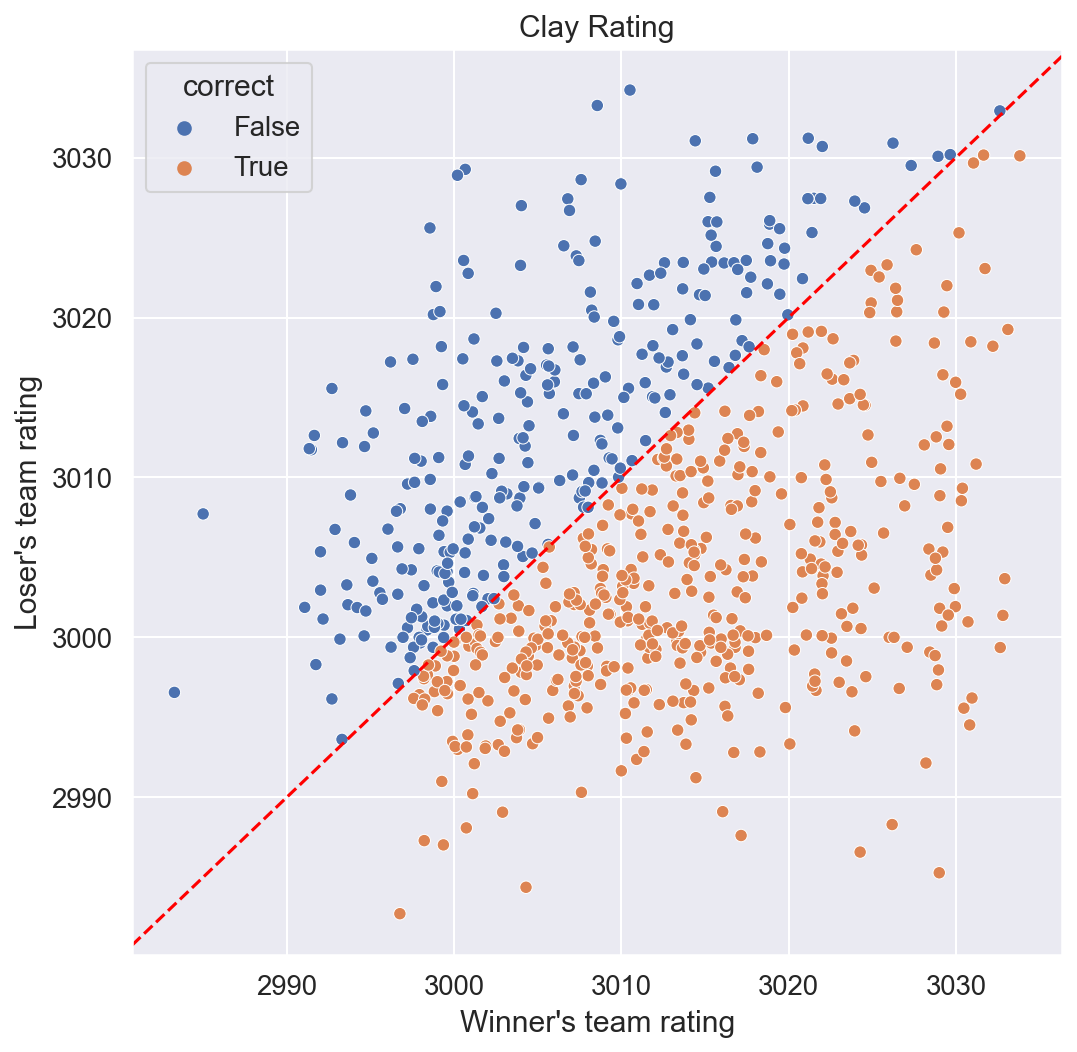

In [42]:
sns.set(font_scale = 1.2)
plt.figure(figsize= (8,8),dpi =150)
c = sns.scatterplot(x=clay['winner'],y=clay['loser'],data = clay,hue = 'correct')
plt.title('Clay Rating')
plt.xlabel('Winner\'s team rating')
plt.ylabel('Loser\'s team rating')
c.axline((2994,2994),(3012,3012),color = 'red',linestyle = '--')
plt.savefig('C:/Users/ching/Desktop/paper/image/clay_rating.png')

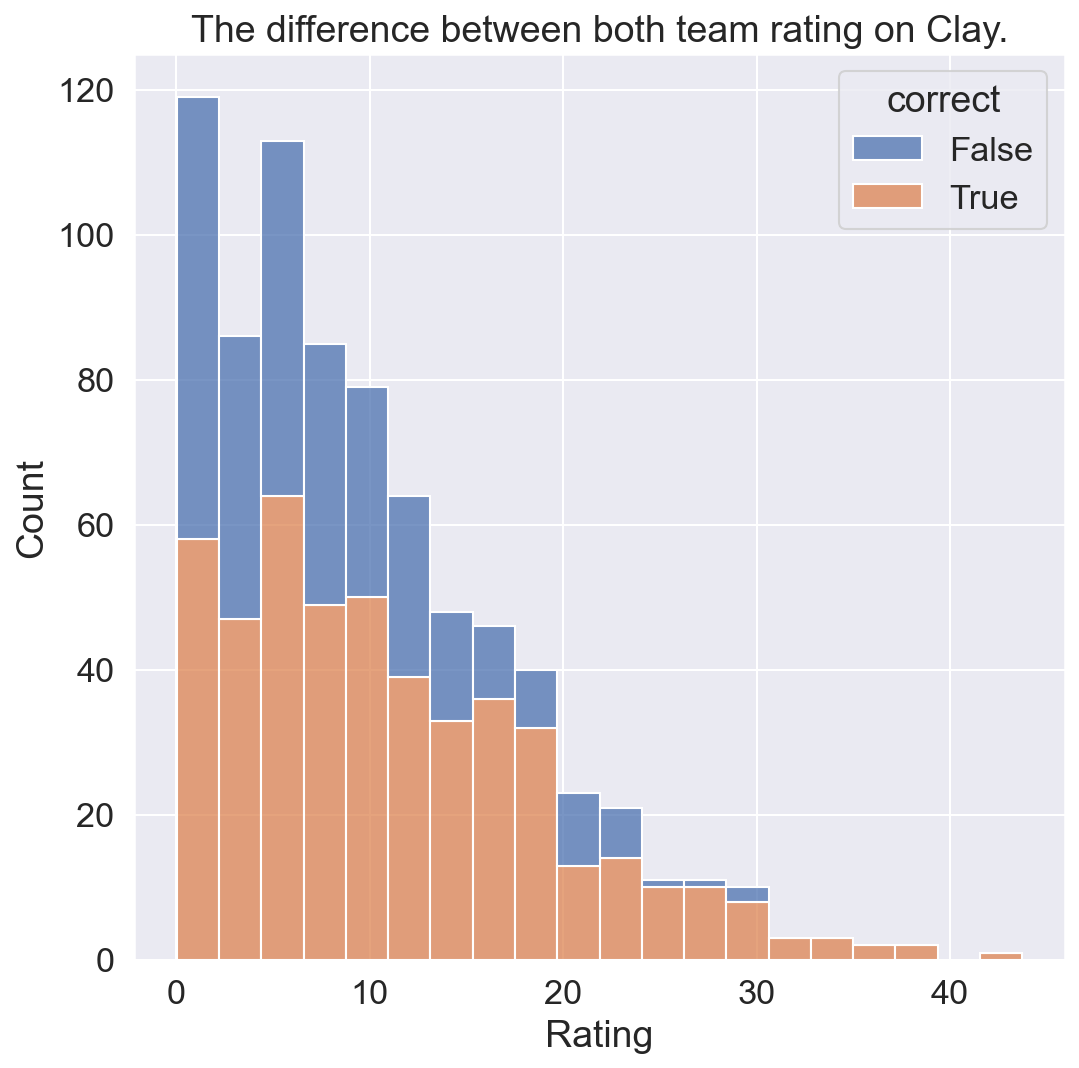

In [43]:
sns.set(font_scale = 1.5)
plt.figure(figsize= (8,8),dpi =150)
diff = sns.histplot(data = clay , x = clay['diff'],hue = 'correct',multiple="stack")
diff.set(xlabel = 'Rating',
         title = 'The difference between both team rating on Clay.')
plt.savefig('C:/Users/ching/Desktop/paper/image/clay_rating_diff.png')

## grass rating

In [44]:
grass = pd.DataFrame(rating[1],columns=['winner','loser'])
grass['Difference'] = grass['winner'] - grass['loser']
grass['diff'] = grass['Difference'].apply(lambda x:abs(x))
grass['correct'] = grass['Difference'].apply(lambda x:True if x > 0 else False)

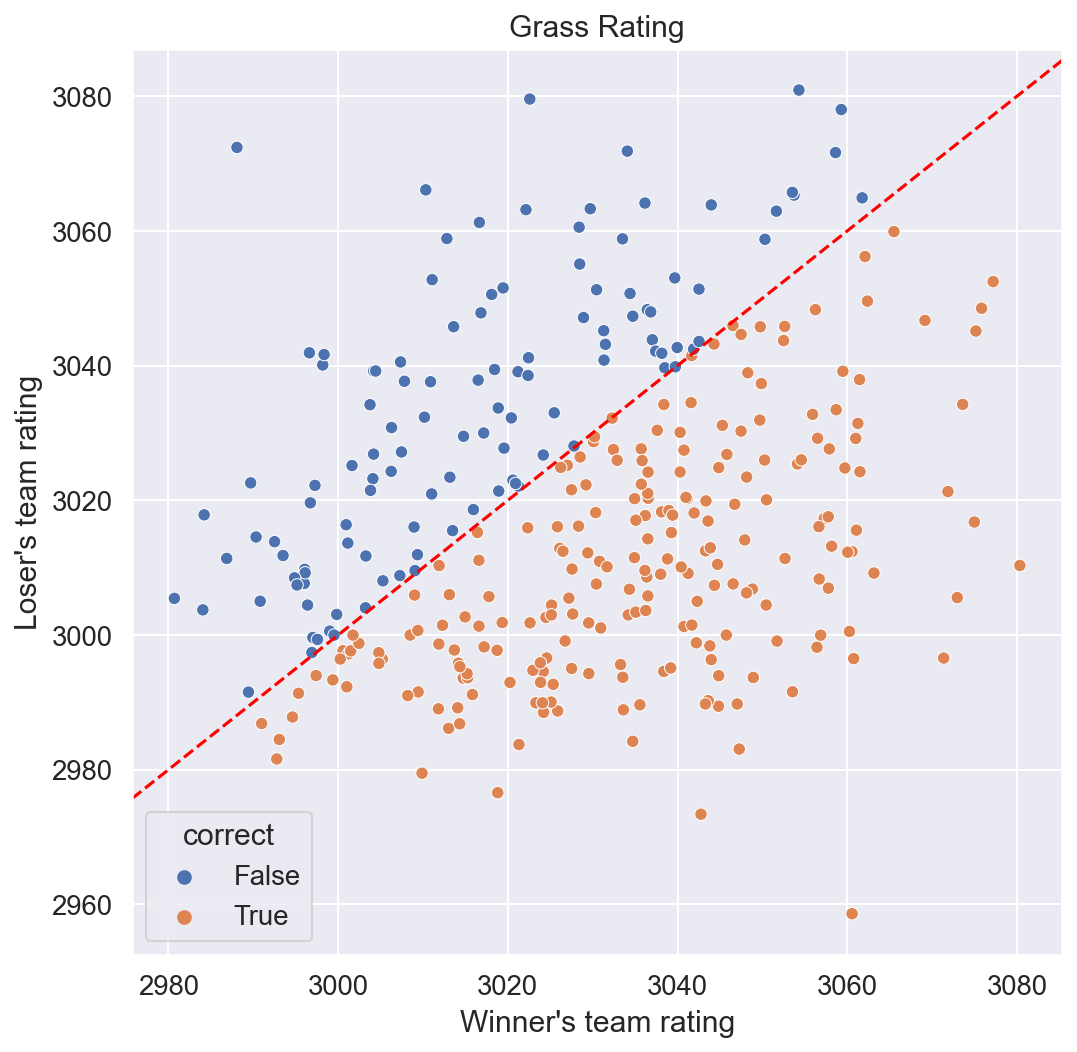

In [45]:
sns.set(font_scale = 1.2)
plt.figure(figsize= (8,8),dpi =150)
c = sns.scatterplot(x=grass['winner'],y=grass['loser'],data = grass,hue = 'correct')
plt.title('Grass Rating')
plt.xlabel('Winner\'s team rating')
plt.ylabel('Loser\'s team rating')
c.axline((2994,2994),(3012,3012),color = 'red',linestyle = '--')
plt.savefig('C:/Users/ching/Desktop/paper/image/grass_rating.png')

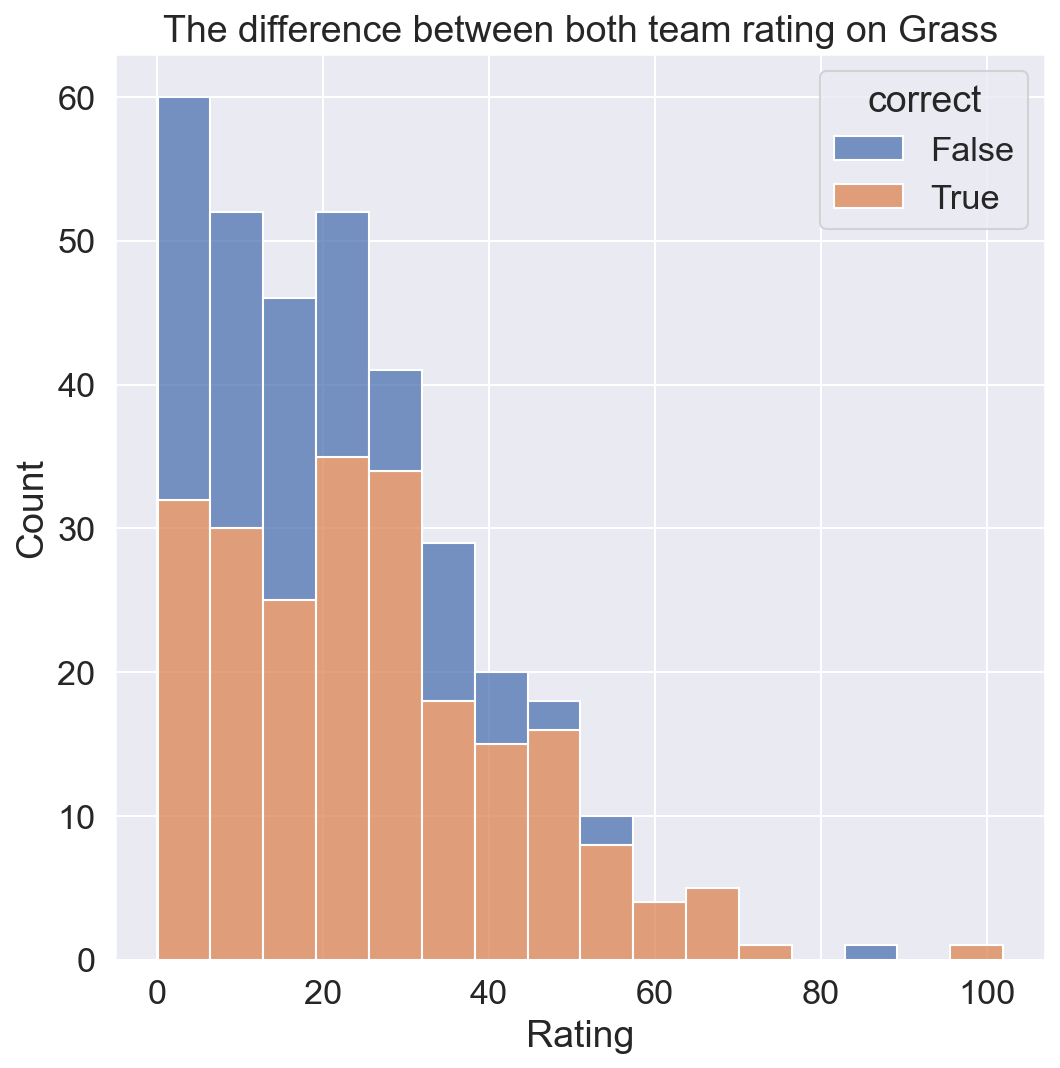

In [46]:
sns.set(font_scale = 1.5)
plt.figure(figsize= (8,8),dpi =150)
diff = sns.histplot(data = grass , x = grass['diff'],hue = 'correct',multiple="stack")
diff.set(xlabel = 'Rating',
         title = 'The difference between both team rating on Grass')
plt.savefig('C:/Users/ching/Desktop/paper/image/grass_rating_diff.png')

## hard rating

In [47]:
hard = pd.DataFrame(rating[2],columns=['winner','loser'])
hard['Difference'] = hard['winner'] - hard['loser']
hard['diff'] = hard['Difference'].apply(lambda x:abs(x))
hard['correct'] = hard['Difference'].apply(lambda x:True if x > 0 else False)

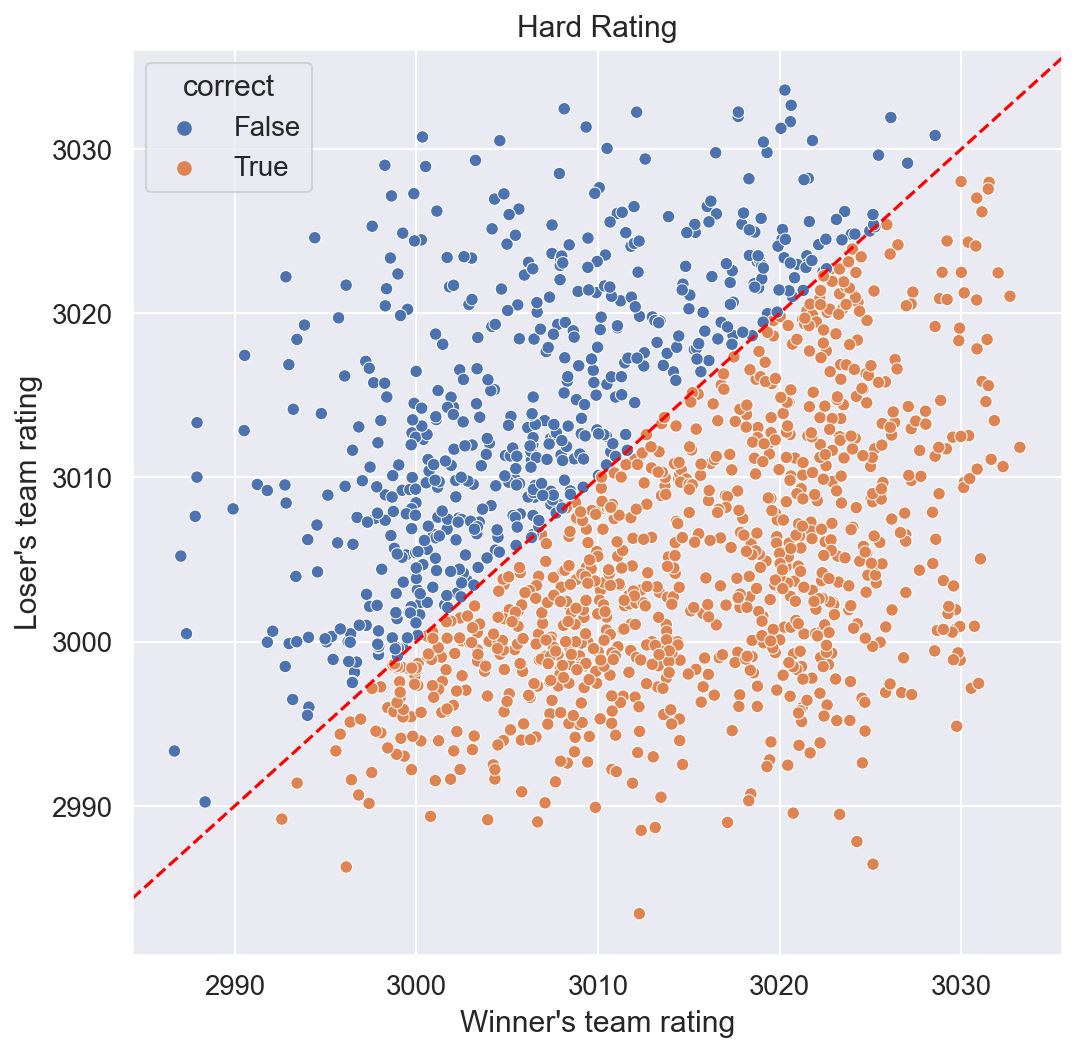

In [48]:
sns.set(font_scale = 1.2)
plt.figure(figsize= (8,8),dpi =150)
c = sns.scatterplot(x=hard['winner'],y=hard['loser'],data = hard,hue = 'correct')
plt.title('Hard Rating')
plt.xlabel('Winner\'s team rating')
plt.ylabel('Loser\'s team rating')
c.axline((2994,2994),(3012,3012),color = 'red',linestyle = '--')
plt.savefig('C:/Users/ching/Desktop/paper/image/hard_rating.png')

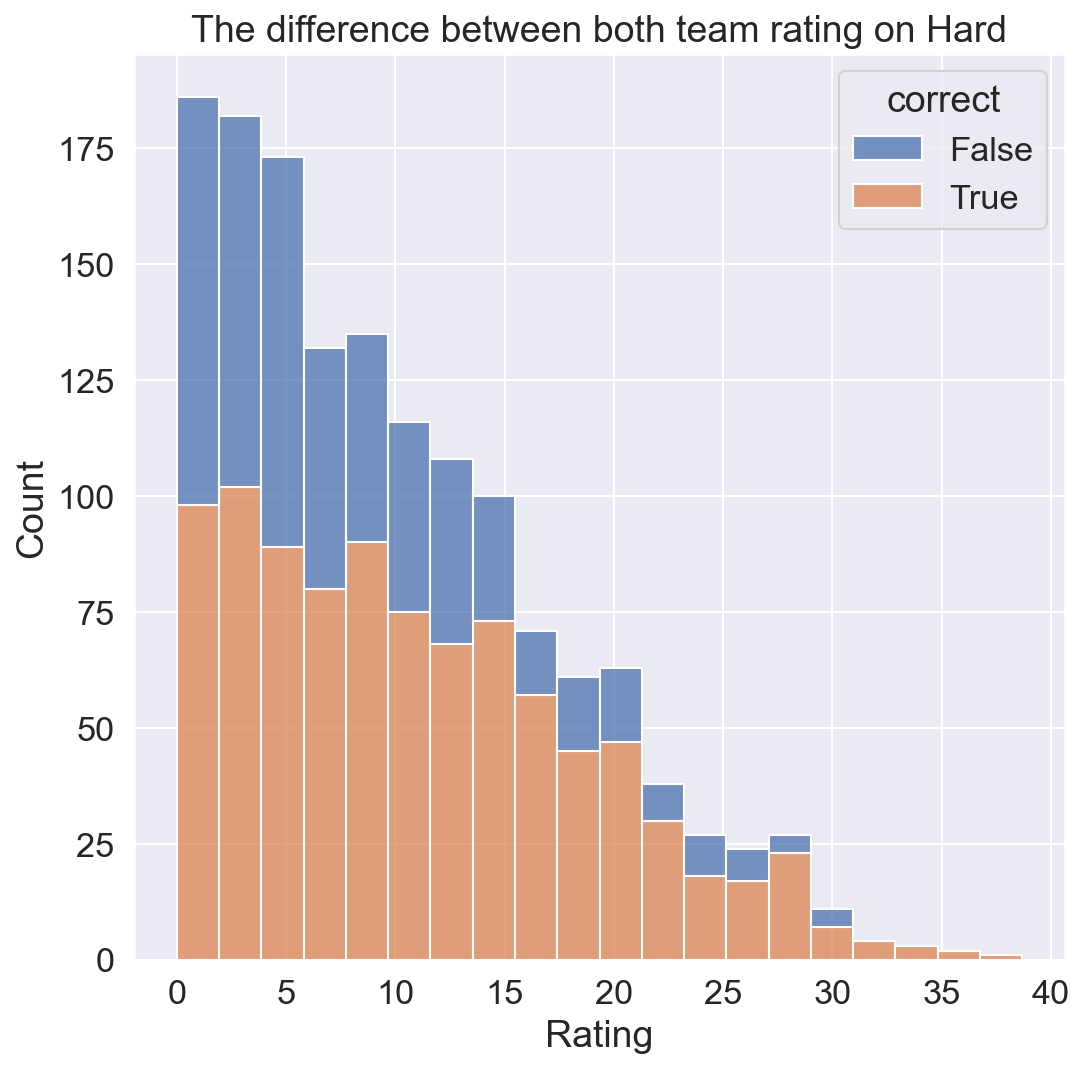

In [49]:
sns.set(font_scale = 1.5)
plt.figure(figsize= (8,8),dpi =150)
diff = sns.histplot(data = hard , x = hard['diff'],hue = 'correct',multiple="stack")
diff.set(xlabel = 'Rating',
         title = 'The difference between both team rating on Hard')
plt.savefig('C:/Users/ching/Desktop/paper/image/hard_rating_diff.png')

# Player

In [88]:
to_use_winners = to_use[['winner1_name','winner2_name']]
to_use_losers = to_use[['loser1_name','loser2_name']]
to_use_surface = encode_marks(to_use['surface'])[0]

In [71]:
player_ratings = calculate_ratings(winners= to_use_winners,
                                             losers= to_use_losers,
                                             surface= to_use_surface,
                                             beta=3**2, 
                               variance_1 = train_parameter[1]['variance_1'], 
                               variance_2 = train_parameter[1]['variance_2'], 
                               variance_3 = train_parameter[1]['variance_3'], 
                               rho_12 = train_parameter[1]['rho_12'], 
                               rho_13 = train_parameter[1]['rho_13'],
                               rho_23 = train_parameter[1]['rho_23'])

In [72]:
player_ratings[0][-1]['Mike Bryan']

array([[1512.62815908],
       [1520.14432735],
       [1510.25423671]])

In [73]:
player_ratings[0][-1]['Bob Bryan']

array([[1514.08007185],
       [1523.36379898],
       [1511.60688495]])

In [101]:
tour_2018 = to_use[to_use['tourney_name']=='Tour Finals'][to_use[to_use['tourney_name']=='Tour Finals']['tourney_date'].dt.year==2018]

In [104]:
tour_2018

,index,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner1_id,winner2_id,winner_seed,winner_entry,loser1_id,loser2_id,loser_seed,loser_entry,score,best_of,round,winner1_name,winner1_hand,winner1_ht,winner1_ioc,winner1_age,winner2_name,winner2_hand,winner2_ht,winner2_ioc,winner2_age,loser1_name,loser1_hand,loser1_ht,loser1_ioc,loser1_age,loser2_name,loser2_hand,loser2_ht,loser2_ioc,loser2_age,winner1_rank,winner1_rank_points,winner2_rank,winner2_rank_points,loser1_rank,loser1_rank_points,loser2_rank,loser2_rank_points,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,round_number,year,pts_won_serve_winner,pts_won_serve_loser,pts_played_serve_winner,pts_played_serve_loser,spw_winner,spw_loser
11090,23650,2018-0605,Tour Finals,Hard,8.0,F,2018-11-12,282,103997,104249,3.0,NaN,103594,106207.0,1.0,NaN,7-6(4) 6-4,3,RR,Lukasz Kubot,R,190.0,POL,36.492813,Marcelo Melo,R,203.0,BRA,35.137577,Oliver Marach,R,185.0,AUT,38.324435,Mate Pavic,L,NaN,CRO,25.357974,7.0,5160.0,7.0,5160.0,2.0,7250.0,3.0,7250.0,100.0,9.0,4.0,68.0,46.0,33.0,12.0,11.0,2.0,4.0,5.0,7.0,65.0,36.0,27.0,12.0,11.0,2.0,5.0,1,2018,45.0,39.0,68.0,65.0,0.661765,0.600000
11091,23651,2018-0605,Tour Finals,Hard,8.0,F,2018-11-12,281,103185,106058,5.0,NaN,103594,106207.0,1.0,NaN,6-4 7-6(4),3,RR,Mike Bryan,R,190.0,USA,40.539357,Jack Sock,R,185.0,USA,26.132786,Oliver Marach,R,185.0,AUT,38.324435,Mate Pavic,L,NaN,CRO,25.357974,1.0,9585.0,4.0,6625.0,2.0,7250.0,3.0,7250.0,83.0,7.0,3.0,59.0,34.0,29.0,18.0,11.0,0.0,1.0,4.0,6.0,64.0,35.0,28.0,15.0,11.0,6.0,8.0,1,2018,47.0,43.0,59.0,64.0,0.796610,0.671875
11092,23652,2018-0605,Tour Finals,Hard,8.0,F,2018-11-12,280,103594,106207,1.0,NaN,105732,103917.0,8.0,NaN,6-4 7-6(3),3,RR,Oliver Marach,R,185.0,AUT,38.324435,Mate Pavic,L,NaN,CRO,25.357974,Pierre Hugues Herbert,R,188.0,FRA,27.655031,Nicolas Mahut,R,190.0,FRA,36.807666,2.0,7250.0,3.0,7250.0,17.0,3640.0,15.0,4080.0,106.0,4.0,2.0,61.0,45.0,36.0,11.0,11.0,1.0,2.0,3.0,6.0,70.0,38.0,28.0,16.0,11.0,3.0,5.0,1,2018,47.0,44.0,61.0,70.0,0.770492,0.628571
11093,23653,2018-0605,Tour Finals,Hard,8.0,F,2018-11-12,279,103185,106058,5.0,NaN,103997,104249.0,3.0,NaN,6-3 7-6(5),3,RR,Mike Bryan,R,190.0,USA,40.539357,Jack Sock,R,185.0,USA,26.132786,Lukasz Kubot,R,190.0,POL,36.492813,Marcelo Melo,R,203.0,BRA,35.137577,1.0,9585.0,4.0,6625.0,7.0,5160.0,7.0,5160.0,86.0,5.0,3.0,70.0,51.0,40.0,8.0,11.0,4.0,4.0,6.0,6.0,58.0,38.0,32.0,7.0,10.0,2.0,3.0,1,2018,48.0,39.0,70.0,58.0,0.685714,0.672414
11094,23654,2018-0605,Tour Finals,Hard,8.0,F,2018-11-12,278,105732,103917,8.0,NaN,103997,104249.0,3.0,NaN,6-2 6-4,3,RR,Pierre Hugues Herbert,R,188.0,FRA,27.655031,Nicolas Mahut,R,190.0,FRA,36.807666,Lukasz Kubot,R,190.0,POL,36.492813,Marcelo Melo,R,203.0,BRA,35.137577,17.0,3640.0,15.0,4080.0,7.0,5160.0,7.0,5160.0,70.0,4.0,1.0,44.0,36.0,31.0,5.0,9.0,0.0,0.0,0.0,5.0,53.0,32.0,24.0,8.0,9.0,4.0,7.0,1,2018,36.0,32.0,44.0,53.0,0.818182,0.603774
11095,23655,2018-0605,Tour Finals,Hard,8.0,F,2018-11-12,277,105732,103917,8.0,NaN,103185,106058.0,5.0,NaN,6-2 6-2,3,RR,Pierre Hugues Herbert,R,188.0,FRA,27.655031,Nicolas Mahut,R,190.0,FRA,36.807666,Mike Bryan,R,190.0,USA,40.539357,Jack Sock,R,185.0,USA,26.132786,17.0,3640.0,15.0,4080.0,1.0,9585.0,4.0,6625.0,52.0,2.0,0.0,42.0,28.0,25.0,7.0,8.0,2.0,2.0,0.0,1.0,42.0,28.0,19.0,5.0,8.0,4.0,8.0,1,2018,32.0,24.0,42.0,42.0,0.761905,0.571429
11096,23656,2018-0605,Tour Finals,Hard,8.0,F,2018-11-12,276,104679,103946,4.0,NaN,108701,104857.0,2.0,NaN,6-4 6-3,3,RR,Jamie Murray,L,190.0,GBR,32.744695,Bruno Soares,R,180.0,BRA,36.706366,Juan Sebastian Cabal,R,NaN,COL,32.550308,Robert Farah,R,193.0,COL,31.811088,9.0,4940.0,9.0,4940.0,5.0,5785.0,5.0,5785.0,73.0,1.0,1.0,56.0,37.0,25.0,13.0,10.0,4.0,6.0,0.0,2.0,50.0,40.0,24.0,4.0,9.0,4.0,8.0,1,2018,38.0,28.0,56.0,50.0,0.678571,0.560000
11097,23657,2018-0605,Tour Finals,Hard,8.0,F,2018-11-12,275,108701,104857,2.0,NaN,104071,105030.0,